# Analysis of airbnb Munich Data

For an introduction, see Readme.md file

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib.patches import Rectangle
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
from matplotlib.ticker import LogLocator
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

### Data Files & Connections

* **df_listings** contains the offers (i.e. locations) by the hosts
* **df_neighbourhoods** contains the unique list of neighbourhoods
* **df_reviews** contains the (textual) reviews inkl. date per listing, a reviewer has a unique ID
* **df_calendar** contains per listing and date the price, min / max stay duration and availability, data is available for ~1y in advance

Connections:
* df_listings.neighbourhood_cleansed --> df_neighbourhoods.neighbourhood
* df_reviews.listing_id --> df_listings.id
* df_calendar.listing_id --> df_listings.id

In [2]:
# Open CSV Files as provided by airbnb...
# (only these are needed)
df_calendar = pd.read_csv('./Munich/calendar.csv')
df_listings = pd.read_csv('./Munich/listings.csv')

## Check for Missing Values or Unwanted Duplicates
Check for missing values in relevant columns / dataframes...

--> *As can be seen below, all relevant columns have no missing values*

In [3]:
print("Columns in df_calendar with missing values:")
np.sum(df_calendar.isnull())/df_calendar.shape[0]

Columns in df_calendar with missing values:


listing_id        0.0
date              0.0
available         0.0
price             0.0
adjusted_price    0.0
minimum_nights    0.0
maximum_nights    0.0
dtype: float64

In [4]:
print("Relevant columns in df_listings with missing values:")
np.sum(df_listings[['id', 'neighbourhood_cleansed']].isnull())/df_listings.shape[0]

Relevant columns in df_listings with missing values:


id                        0.0
neighbourhood_cleansed    0.0
dtype: float64

In [5]:
# Listing's ID is unique...
print("Number of duplicate listing IDs in listings data frame: " + str(df_listings['id'].drop_duplicates().shape[0] - df_listings['id'].shape[0]))

Number of duplicate listing IDs in listings data frame: 0


## Data Preparation

We calculate additional columns for our analysis

In [6]:
def datetime_to_weekday( dt ):
    '''Returns the weekday of the given datetime object.
    
    Helper function so that it can be used to calculate a column.'''
    return dt.weekday()

# Parse date into a datetime field.
# Per default, a datatime date has time 00:00 - which would lead to points in visus at the beginning of the day
# But we want the point to be in the middle of the day...
df_calendar['date'] = pd.to_datetime(df_calendar['date']) + dt.timedelta(hours=12)
df_calendar['weekday'] = df_calendar['date'].apply(datetime_to_weekday)

# Parse prices into numeric fields
# To ease parsing, remove all that is not absolutelty needed
df_calendar['adjusted_price'] = pd.to_numeric( df_calendar['adjusted_price'].str.replace("$","").str.replace(",","") )
df_calendar['price'] = pd.to_numeric( df_calendar['price'].str.replace("$","").str.replace(",","") )

# Join the neighborhood to the offerings
df_calendar = df_calendar.merge( df_listings[['id', 'neighbourhood_cleansed']], how='left', left_on=['listing_id'], right_on=['id'] ).drop('id', axis=1)

## Analysis

### Descriptive Check

First some descriptive statistics to get an impression of the data...

In [7]:
df_calendar['minimum_nights'].describe()
# -> The great majority of offerings is for 5 nights and less.
# -> On average, 10 nights are offered --> there is a group of people offering stays >> 5 nights.

count    1.774265e+06
mean     9.144664e+00
std      2.864365e+01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      8.000000e+02
Name: minimum_nights, dtype: float64

In [8]:
df_calendar['adjusted_price'].describe()
# -> The majority (75%) of prices per night is < 150$. Nevertheless, there are nights offered for up to 17937$ !!
# -> large std deviation when looking at the overall average / price, to be looked into in more detail

count    1.774265e+06
mean     1.461355e+02
std      3.123731e+02
min      0.000000e+00
25%      6.000000e+01
50%      9.000000e+01
75%      1.490000e+02
max      1.793700e+04
Name: adjusted_price, dtype: float64

<AxesSubplot:>

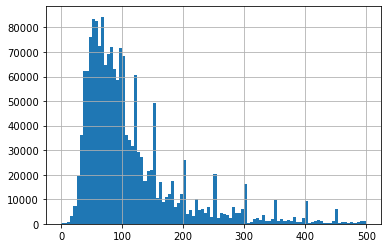

In [9]:
df_calendar[ df_calendar['adjusted_price'] < 500 ]['adjusted_price'].hist(bins=100)
# -> There are standard prices visible in the histogram that hosts seem to prefer offering
#    (sticking out peaks in the slope, ~120, 150, 200, 250, 300, 350, 400, 450)

<AxesSubplot:xlabel='date'>

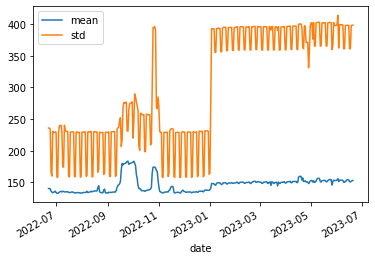

In [10]:
df_calendar.groupby('date')['adjusted_price'].agg([np.mean, np.std]).plot(kind="line")
# -> Overall, we can see a higher mean & stddev starting directly 1.1.2023....
# -> In 2022 data also more specifics are visible than in 2023.

In [11]:
df_calendar['weekday'].value_counts()
# -> Offering across the weeks seems to be rather constant - slightly increaesed on Tuesdays

1    257633
6    252772
5    252772
4    252772
3    252772
2    252772
0    252772
Name: weekday, dtype: int64

In [12]:
df_calendar[ df_calendar['date'] > dt.datetime(2022,12,31) ].groupby('weekday')['adjusted_price'].agg([np.mean, np.std])
# -> General variance between weekdays not visible on overall level
# -> The little variations in average price have no significance

mean         std
weekday                        
0        151.693816  396.983470
1        151.638288  395.819154
2        151.526803  394.699072
3        151.677810  395.861673
4        149.602799  361.251278
5        149.005052  354.476002
6        150.953524  392.851983

In [13]:
# Looking at the std dev per day, then averaging this per weekday
# (weekday number: 0 -> Monday, 4 -> Friday, ...)
# Here for 2022 data (as it is more specific and has less std dev as seen above)
df_calendar[ df_calendar['date'] > dt.datetime(2022,12,31) ].groupby(['weekday', 'date'])['adjusted_price'].agg(np.std).groupby('weekday').agg([np.mean, np.std, np.median])
# -> The weekend nights (Fri->Sat, Sat->Sun have significant less spread in the offerings)

mean        std      median
weekday                                   
0        397.006521   2.774682  395.998982
1        395.803342   6.078368  395.696189
2        394.664851   7.184427  395.653906
3        395.851782   6.042006  395.771447
4        361.056068  12.940595  359.244673
5        352.410528  39.243130  359.324875
6        392.125700  24.836280  396.129281

### More Detailed Analysis

Based on the descriptive check, a more detailed look into the drivers of the adjusted price is taken.

#### Support Functions

These are for creating graphs of mean and standard deviation.

In [14]:
insert_area_note?

Object `insert_area_note` not found.


In [15]:
def insert_area_note( ax, text, x_start, x_end, y_min, y_max, color = 'green' ):
    '''Creates an rectangular area covering whole y-Axis range with a text aligned to the top.
    
    Parameters:
    * ax - axis to draw on
    * text - the text to write (use '\\n's to insert line breaks)
    * x_start, x_end - start and end of the area to be colored in values on the X axis
    * y_min, y_max - start and end of the area to be colored in values on the Y axis
    * color - color to be used, defaults to 'green'
    '''
    ax.add_patch(
        Rectangle((x_start, y_min), x_end-x_start+0.9, y_max-y_min
                 , edgecolor = 'black'
                 , facecolor = color
                 , fill=True
                 , alpha=0.1
                 , lw=2
                 )
    )

    ax.annotate(text, xy=( x_start + (x_end-x_start)/2, y_max - (y_max-y_min)*0.05),  xycoords='data'
                , arrowprops=dict(facecolor='black')
                , horizontalalignment='center', verticalalignment='top'
                , size='large'
                )


def insert_notes( df_eventlist, axis, ax_min, ax_max ):
    '''Inserts color areas for all events in the list into the given graph and Axis.
    
    This function uses insert_area_note for all events in the passed event list.
    
    Parameters:
    * df_eventlist - The notes have to be in df_eventlist data frame, with columns
      Event, From (as datetime), To (as datetime), color.
    * axis - the axis to draw on (datetime axis)
    * ax_min, ax_max - the min and max values for the Y axis to be used for drawing.'''
    
    # Ensure that index is without gaps / correct...
    df = df_eventlist.reset_index()
    for i in range(0, len(df.index)):
        insert_area_note( axis
                         , df.loc[i]['Event']
                         , mdates.date2num(df.loc[i]['From'])
                         , mdates.date2num(df.loc[i]['To'])
                         , ax_min, ax_max
                         , df.loc[i]['Color'] )

# We need to make these functions explicit, otherise naming
# of the aggregated data column is funny (it takes the function name)

def percentile50(df):
    '''Returns the 50% percentile of the given column'''
    return np.percentile(df, 50)

def percentile10(df):
    '''Returns the 10% percentile of the given column'''
    return np.percentile(df, 10)

def percentile20(df):
    '''Returns the 20% percentile of the given column'''
    return np.percentile(df, 20)

def percentile90(df):
    '''Returns the 90% percentile of the given column'''
    return np.percentile(df, 90)

def percentile75(df):
    '''Returns the 75% percentile of the given column'''
    return np.percentile(df, 75)
        
def create_meanstd_figure( df_data, df_eventlist, scope = 'Munich Overall', df_ref_mean = None, df_ref_std = None, axis = None, figsize = (20,10) ):
    '''Creates a figure with mean and std deviation plotted in it for the calendar data frame.
    Using the given event list data frame, events are marked.
    
    Parameters:
    * df_data - the calendar data from of the airbnb data
    * df_eventlist - the list of events as described under insert_notes function
    * scope - the title of the scope for which the df_data is given (eg. a neighborhood, defaults to "Munich Overall")
    * df_ref_mean - reference data set with date and average price (labeled "Munich overall" in graphs, column must be called "mean")
    * df_ref_std - reference data set with date and std dev of average price (labeled "Munich overall" in graphs, column must be called "std")
    * axis - the axis to draw on, defaults to None meaning a new plot is generated
    * figsize - the size of the to be created figure as a touple, defaults to (20, 10)
    
    *Note:*
    Labeling for legends via workaround - usage of column names, as 'label =' parameter does not work.
    Therefore, reference data frames columns must be named "mean" resp. "std".'''

    # First define all graphs on the price axis...
    # Title, dataframe, colname, linestyle, color
    # df_means is special, as it is returned at the end
    df_means = df_data.groupby('date')['adjusted_price'].agg([np.mean])
    price_graphs = [
        [ 'Mean',            df_means,                                                       'mean', 'solid', 'blue' ],
        [ 'Median',          df_data.groupby('date')['adjusted_price'].agg([np.median]),     'median', 'dashed', 'lightblue' ],
        [ '20th Percentile', df_data.groupby('date')['adjusted_price'].agg([percentile20]),  'percentile20', 'dotted', 'lightblue' ],
        [ '75th Percentile', df_data.groupby('date')['adjusted_price'].agg([percentile75]),  'percentile75', 'dotted', 'lightblue' ]
        #[ '90th Percentile', df_data.groupby('date')['adjusted_price'].agg([percentile90]),  'percentile90', 'dotted', 'lightblue' ]
    ]
    if not df_ref_mean is None:
        price_graphs.append(
            [ 'Mean Overall Munich', df_ref_mean, 'mean', 'solid', 'violet' ]
        )

    # Plot price graphs
    min_price = None
    max_price = None

    ax = axis
    for g in price_graphs:
        min_price = min( min(g[1][g[2]]), min_price ) if min_price else min(g[1][g[2]])
        max_price = max( max(g[1][g[2]]), max_price ) if max_price else max(g[1][g[2]])
        ax = g[1].rename( columns={ g[2]: "{} {}".format(g[0], scope) } ).plot(
            kind="line", figsize=figsize, color=g[4], linestyle=g[3],
            ax = ax)#,
            #title="Adjusted Price and Std Deviation for " + scope)
        plt.title("Adjusted Price and Std Deviation for " + scope, fontsize=16)

    # Set the axis to slightly larger range as the data
    ax_min_price = min_price*0.95
    ax_max_price = max_price*1.05

    # Annotate with explanations...
    insert_notes( df_eventlist, ax, ax_min_price, ax_max_price )
    ax.annotate( 'Markers for events:\n- lightblue: vacation\n- green: fair\n- yellow: other',
                #( max(df_means.index), ax_min_price*1.05 ),
                ( 0.89, 0.93 ),
                xycoords='axes fraction',
                va='top', ha= 'left' )

    ax.set_xlabel('Date of Offering', fontsize = 14)
    
    ax.set_ylim([ax_min_price, ax_max_price])
    # Ticks at ~12 positions
    # Include max (therefore set hight number in arange)
    stepwidth = (max_price-min_price)/12
    ax.set_yticks(np.arange(min_price, max_price + stepwidth/2, stepwidth))
    ax.set_ylabel('Adjusted Price', fontsize = 14)
    ax.legend(loc='upper left')

    # Plot std dev on second axis
    df_std = df_data.groupby('date')['adjusted_price'].agg([np.std])
    ax2 = ax.twinx()
    df_std.rename( columns={'std': 'StdDev ' + scope } ).plot(kind='line', linestyle='dotted', color='red', ax=ax2, label ='StdDev ' + scope)
    if not df_ref_std is None:
        df_ref_std.rename( columns={'std': 'StdDev Overall Munich' } ).plot(kind='line', linestyle='dotted', color='orange', ax=ax2)
    ax2.set_ylabel('Std Dev of Adjusted Price', fontsize = 14)
    ax2.legend(loc='upper right')
    
    # Return the dfs that are used / can be used for reference...
    return[ df_means, df_std ]

#### Event List

A list of events that are deemed / might be relevant

In [16]:
df_events = pd.DataFrame(columns=['EventType', 'Event', 'From', 'To', 'Color'])

# Overview of vacations:
# https://www.schulferien.org/deutschland/ferien/herbst/
df_events.loc[len(df_events.index)] = [ 'Vacation', '\n\n\n\n\n\nChristmas', dt.datetime(2022,12,20), dt.datetime(2022,12,31), 'lightblue' ]
df_events.loc[len(df_events.index)] = [ 'Vacation', 'Autumn', dt.datetime(2022,10,17), dt.datetime(2022,11,1), 'lightblue' ]
df_events.loc[len(df_events.index)] = [ 'Vacation', 'Summer Vacation', dt.datetime(2022,7,18), dt.datetime(2022,8,21), 'lightblue' ]
df_events.loc[len(df_events.index)] = [ 'Vacation', 'Easter\nHolidays', dt.datetime(2023,4,3), dt.datetime(2023,4,14), 'lightblue' ]

# Fairs
df_events.loc[len(df_events.index)] = [ 'Fair', '\n\nBauMa', dt.datetime(2022,10,24), dt.datetime(2022,10,30), 'green' ]
df_events.loc[len(df_events.index)] = [ 'Fair', '\n\nISPO', dt.datetime(2022,11,28), dt.datetime(2022,11,30), 'green' ]
df_events.loc[len(df_events.index)] = [ 'Fair', 'electronica', dt.datetime(2022,11,15), dt.datetime(2022,11,18), 'green' ]
df_events.loc[len(df_events.index)] = [ 'Fair', 'Bau', dt.datetime(2023,4,17), dt.datetime(2023,4,22), 'green' ]
df_events.loc[len(df_events.index)] = [ 'Fair', 'f.r.e.e.', dt.datetime(2023,2,22), dt.datetime(2023,2,26), 'green' ]
df_events.loc[len(df_events.index)] = [ 'Fair', 'IHM/Garten', dt.datetime(2023,3,8), dt.datetime(2023,3,12), 'green' ]


# Other events
df_events.loc[len(df_events.index)] = [ 'Other', '\n\nEuropean\nChampionships', dt.datetime(2022,8,11), dt.datetime(2022,8,21), 'yellow' ]
df_events.loc[len(df_events.index)] = [ 'Other', 'Oktoberfest', dt.datetime(2022,9,17), dt.datetime(2022,10,3), 'yellow' ]
df_events.loc[len(df_events.index)] = [ 'Other', '\n\n\n\n\n\n\nRobbie\nWilliams', dt.datetime(2022,8,27), dt.datetime(2022,8,27), 'yellow' ]
df_events.loc[len(df_events.index)] = [ 'Other', '\n\n\n\n\nHelene\nFischer', dt.datetime(2022,8,20), dt.datetime(2022,8,20), 'yellow' ]

#### Events and Their Influence on Price and Standard Deviation

Focus will be 2022, as it looks much more specific as seen above

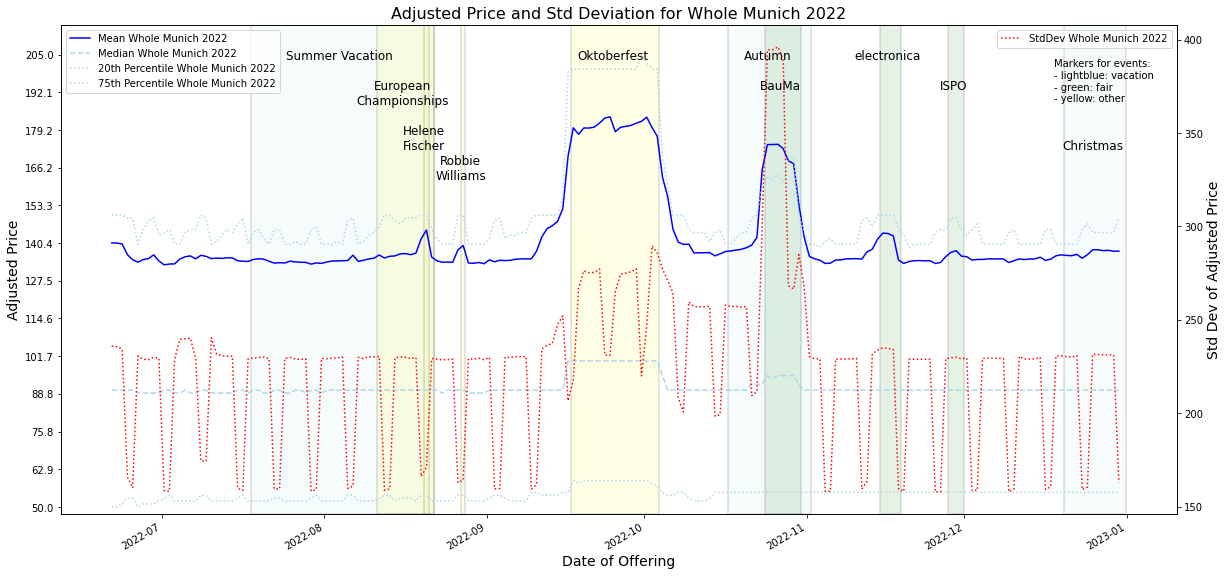

In [17]:
# Subset 2022 data
df_thisyear = df_calendar[ df_calendar['date'] <= dt.datetime(2022,12,31) ]

[ df_ty_ref_mean, df_ty_ref_std ] = create_meanstd_figure( df_thisyear, df_events[ df_events['From'] <= dt.datetime(2022,12,31) ], 'Whole Munich 2022' )

# Results
# - Two biggest effects seem to be Octoberfest and Bauma Fair
# - Unclear Helene or EU Championships / Finals - likely Helene, as spike is sundays and EU Championships have finals
#   per dscipline on all days and not just the last ones
# - Vacations do not seem to have a significant impact on the price (might not be intuitive for new airbnb hosts)
# - Very large fairs do seem to impact the price, but shows a large std dev (> Oktoberfest) --> look more into it
# - The Oktoberfest has the biggest impact on the price

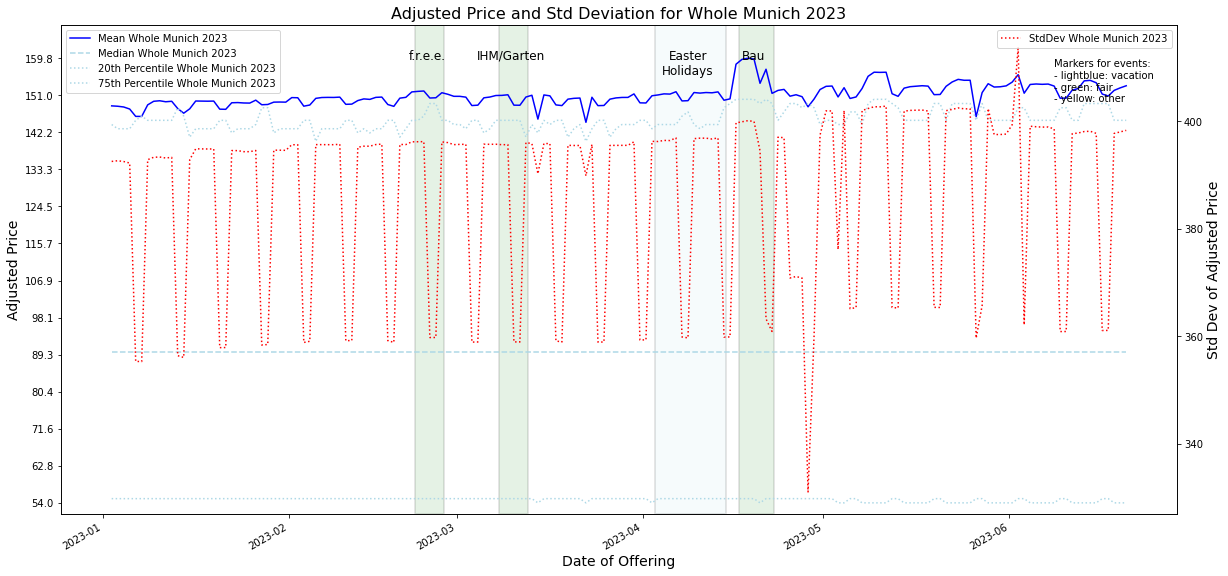

In [18]:
# Check 2023
df_nextyear = df_calendar[ df_calendar['date'] > dt.datetime(2023,1,2) ]
dummy = create_meanstd_figure( df_nextyear, df_events[ df_events['From'] > dt.datetime(2022,12,31) ], 'Whole Munich 2023' )

# -> It again can be seen that the easter holidays which are approximately at the same time in all EU countries do not seem to impact the price
# -> Note that the standard deviation of the prices is much higher for the next year

#### Scatter Plot of Neighborhoods

Based on above observations, a scatterplot is created:
* One bubble per neighborhood
* Bubble sized - number of offerings in neighborhood
* Bubble color - std deviation of over the std deviations per day 
* X axis - average price
* Y axis - average of std deviation per day

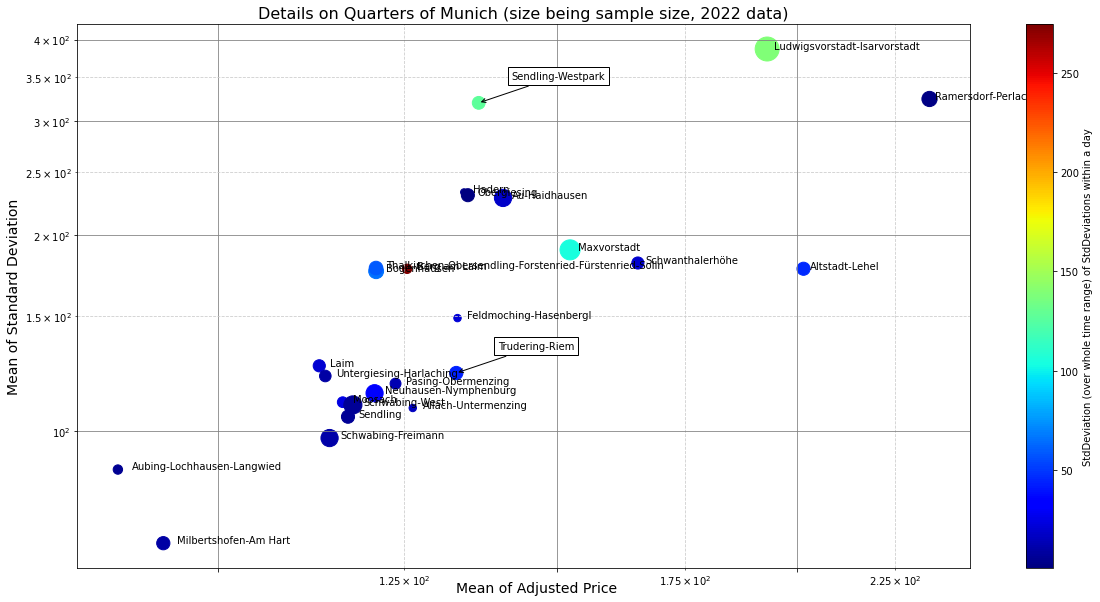

In [19]:
# Create prep data frames
# Number of offerings per neighborhood
counts = df_thisyear.groupby('neighbourhood_cleansed')['listing_id'].agg('nunique').reset_index()
# mean & std dev per neighborhood and date
prep   = df_thisyear.groupby(['neighbourhood_cleansed', 'date'])['adjusted_price'].agg([np.mean, np.std]).reset_index()
# mean, std dev of prep's price mean per neighborhood
prc = prep.groupby('neighbourhood_cleansed')['mean'].agg([min, max, np.mean, np.std]).reset_index().add_prefix('adj_price_')
# mean, std dev of prep's price std dev per neighborhood
std = prep.groupby('neighbourhood_cleansed')['std'].agg([min, max, np.mean, np.std]).reset_index().add_prefix('std_')

# Join all prepared data together so that we have one row per neighborhood cleansed
res = prc.merge( std, how="inner", left_on="adj_price_neighbourhood_cleansed", right_on="std_neighbourhood_cleansed" ) \
  .merge( counts, how="inner", left_on="adj_price_neighbourhood_cleansed", right_on='neighbourhood_cleansed' ) \
  .drop(["adj_price_neighbourhood_cleansed", 'std_neighbourhood_cleansed'], axis = 1) \
  .rename( columns = {
    'listing_id': 'Unique count of listings',
    'std_std': 'StdDeviation (over whole time range) of StdDeviations within a day'
  } )

# Plot it
ax = res.plot(
    kind="scatter",
    #title=
    x="adj_price_mean",
    y="std_mean",
    s="Unique count of listings",
    figsize = (20,10),
    c='StdDeviation (over whole time range) of StdDeviations within a day',
    cmap="jet" )

plt.title('Details on Quarters of Munich (size being sample size, 2022 data)', fontsize=16)

# As in lower price and std dev range we have a bunching, go to log view
ax.set_yscale("log")
ax.set_xscale("log")

# Annotate all bubble with their neighborhood names
# Except the ones that are highlited
nbh_highlited = [ 'Tudering-Riem', 'Sendling-Westpark' ]
for x in res[ ~res['neighbourhood_cleansed'].isin(nbh_highlited) ].iterrows():
    data = x[1]
    plt.annotate( data['neighbourhood_cleansed'], (data['adj_price_mean'] + 1.5, data['std_mean']) )

# Especially mark the two referenced ones...
# Position is hand-tuned!
my_row = res[ res['neighbourhood_cleansed'] == 'Sendling-Westpark' ]
ax.add_artist(
    AnnotationBbox( TextArea('Sendling-Westpark'),
                    (my_row['adj_price_mean'], my_row['std_mean']),
                    xybox=(my_row['adj_price_mean']*1.1, my_row['std_mean']*1.1),
                    xycoords='data',
                    arrowprops=dict(arrowstyle="->")
                   ))

my_row = res[ res['neighbourhood_cleansed'] == 'Tudering-Riem' ]
ax.add_artist(
    AnnotationBbox( TextArea('Trudering-Riem'),
                    (my_row['adj_price_mean'], my_row['std_mean']),
                    xybox=(my_row['adj_price_mean']*1.1, my_row['std_mean']*1.1),
                    xycoords='data',
                    arrowprops=dict(arrowstyle="->")
                   ))

# Format both axis...
ax.xaxis.set_major_locator( LogLocator(base = 10, subs=[ 1, 1.5, 2, 2.5 ]) )
ax.xaxis.set_minor_locator( LogLocator(base = 10, subs=[ 0.5, 1.25, 1.75, 2.25 ]) )
ax.xaxis.grid(True, which="major", color = '0.5')
ax.xaxis.grid(True, which="minor", linestyle='--', color = '0.8')
# Whoknowswhy... setting X Axis label does not work...
dummy = ax.set_xlabel("Mean of Adjusted Price", fontsize=14)
plt.xlabel("Mean of Adjusted Price", fontsize=14, loc='center')
# ... so insert a text box...
plt.text( 133, 56.5, 'Mean of Adjusted Price', fontsize=14)

ax.yaxis.set_major_locator( LogLocator(base = 10, subs=[ 1, 2, 3, 4 ]) )
ax.yaxis.set_minor_locator( LogLocator(base = 10, subs=[ 0.5, 1.5, 2.5, 3.5 ]) )
ax.yaxis.grid(True, which="major", color = '0.5')
ax.yaxis.grid(True, which="minor", linestyle='--', color = '0.8')
dummy = ax.set_ylabel("Mean of Standard Deviation", fontsize=14)

In [20]:
# For reference, the result set:
res

adj_price_min  adj_price_max  adj_price_mean  adj_price_std     std_min  \
0      118.781818     173.309091      126.301460      13.320474   98.857541   
1      174.726744     312.639535      201.559043      34.891065  135.574054   
2      130.800000     170.180000      140.705423       9.612905  219.729817   
3       84.329545     111.602273       88.761599       6.436201   83.603983   
4      107.329545     339.818182      125.453073      37.197553   83.777455   
5      112.009050     173.959276      120.889551      15.580499  149.040387   
6      116.381818     198.381818      133.244654      22.378697  130.114060   
7      126.085106     182.234043      134.284313      12.257418  230.472471   
8      106.527027     137.202703      112.939224       6.047087   95.249142   
9      164.020870     279.099130      192.978923      28.106129  148.498289   
10     136.840796     221.671642      152.447697      20.052568  129.992201   
11      87.617143     115.222857       93.717424       6.894092   60.757383   
12     101.443478     181.217391      116.152467      19.141836   95.817693   
13     111.843537     167.057823      120.662719      13.682087   90.052351   
14     129.911765     153.823529      134.909966       5.630333  229.306834   
15     115.563025     161.058824      123.725127      10.617908  109.201557   
16     221.862069     272.125000      234.344158      13.207421  319.550899   
17     107.582492     137.898990      114.338323       7.442019   84.710043   
18     113.003030     137.690909      117.572178       5.674499  105.495477   
19     152.265306     223.639456      165.325649      17.525382  165.371327   
20     112.093023     137.331395      116.887336       6.193273   97.399672   
21     107.048780     192.798780      136.670163      20.222036  112.602925   
22     106.502703     171.843243      120.871755      17.770420  142.439427   
23     111.914773     254.357955      133.047721      29.485346   91.278099   
24     108.611940     138.947761      113.757559       7.293281  116.405653   

        std_max    std_mean  \
0    175.283355  108.389755   
1    331.802751  177.530331   
2    358.126353  228.205415   
3    108.796953   87.139760   
4   1917.679587  177.501509   
5    379.075399  175.994759   
6    209.857956  149.054813   
7    262.276237  232.884733   
8    215.085607  125.864135   
9    508.704574  386.831251   
10   442.101546  189.828961   
11    94.926781   67.122889   
12   219.262071  110.639356   
13   224.768308  114.216366   
14   232.634372  230.407249   
15   166.315674  118.150635   
16   333.654091  324.046468   
17   128.803341   97.432752   
18   134.548865  109.567103   
19   241.111076  181.189069   
20   126.961446  105.086104   
21   408.508032  319.633006   
22   410.150342  177.979763   
23   308.690779  122.688772   
24   156.803016  121.397347   

    StdDeviation (over whole time range) of StdDeviations within a day  \
0                                           15.690255                    
1                                           46.521097                    
2                                           17.951448                    
3                                            6.040174                    
4                                          274.334670                    
5                                           65.420317                    
6                                           21.229431                    
7                                            4.825086                    
8                                           20.826938                    
9                                          139.002424                    
10                                         104.931850                    
11                                           9.947860                    
12                                          25.294625                    
13                                          33.185736                    
14                              

#### 2022 Data Plots per Neighborhood

To have a visual comparison, plots for 2022 data per neighborhood...

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


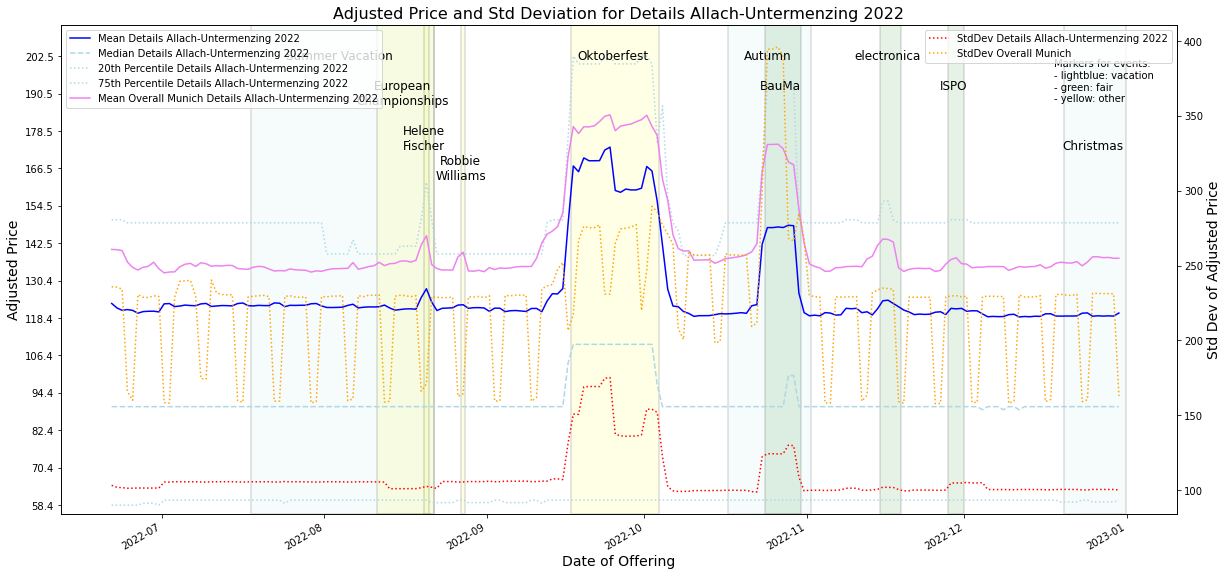

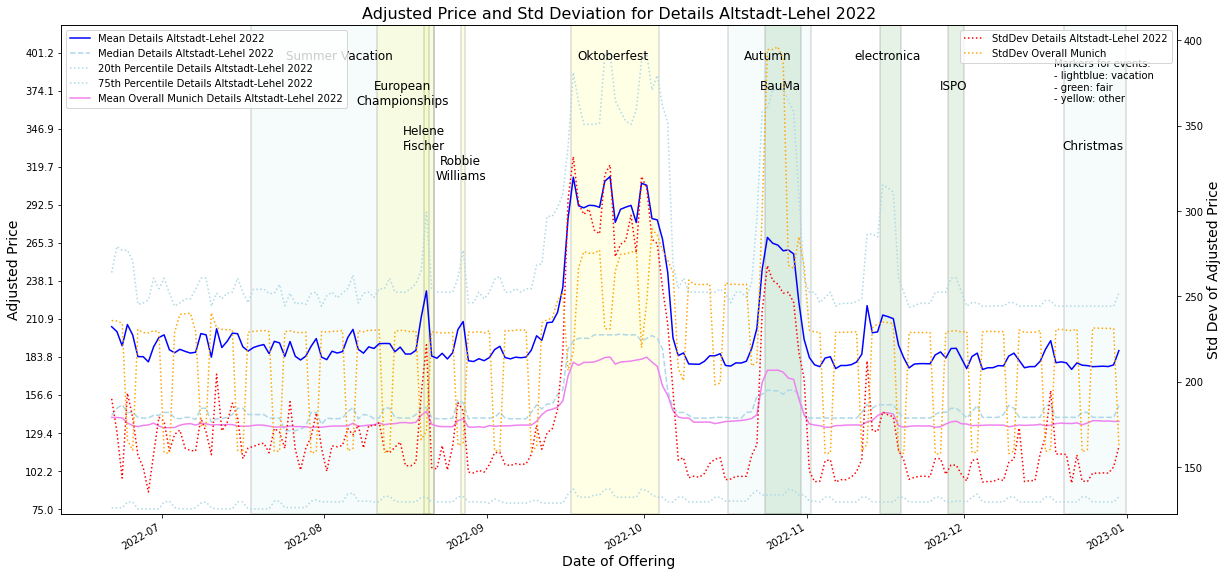

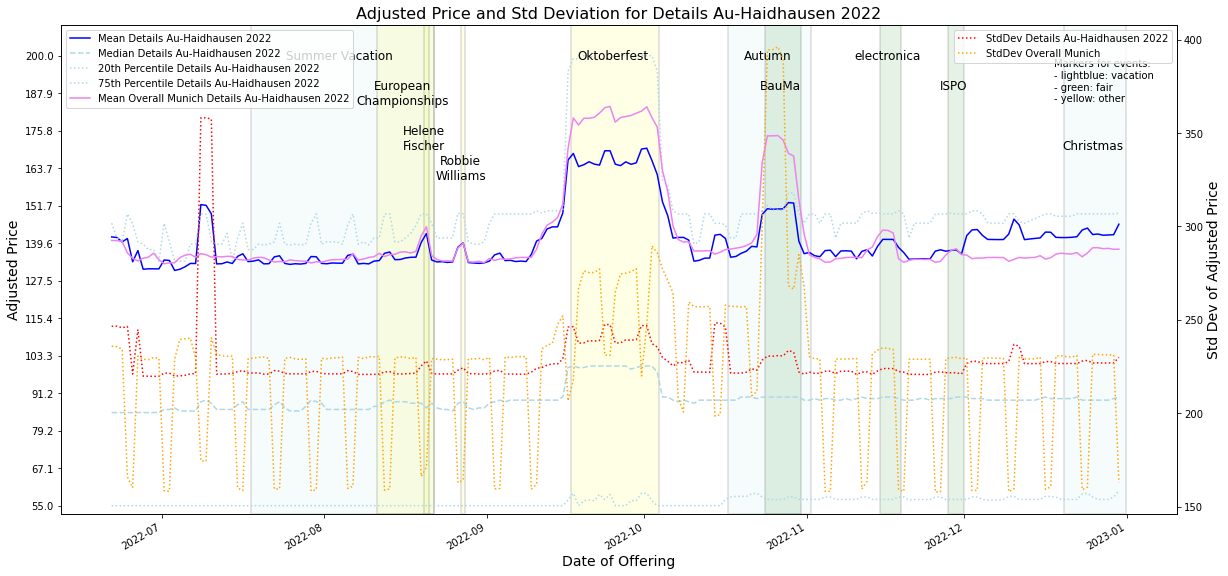

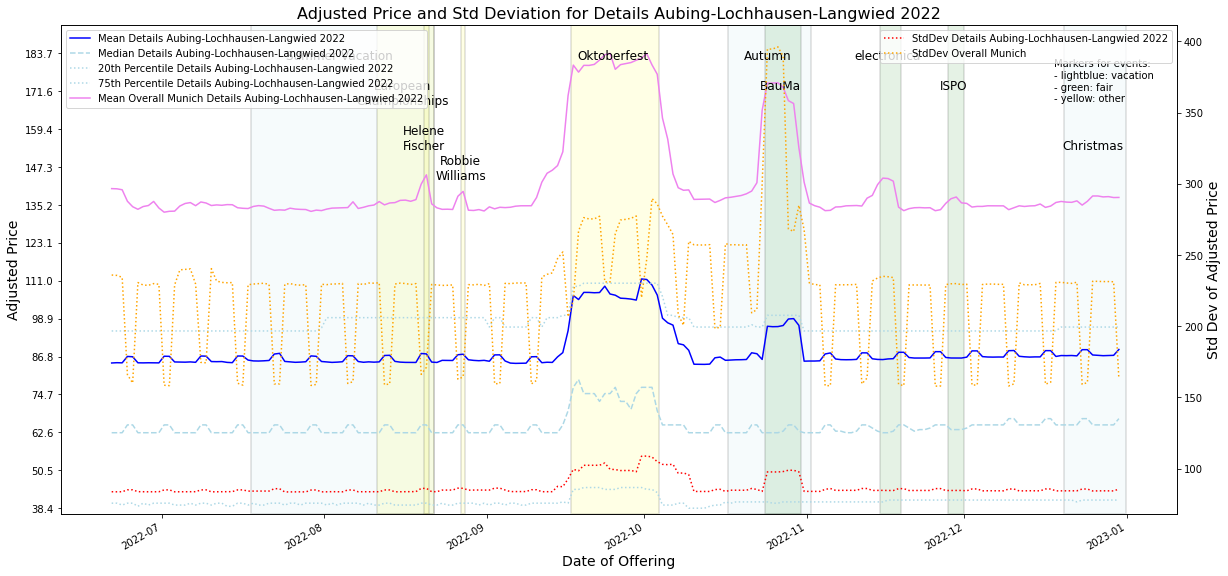

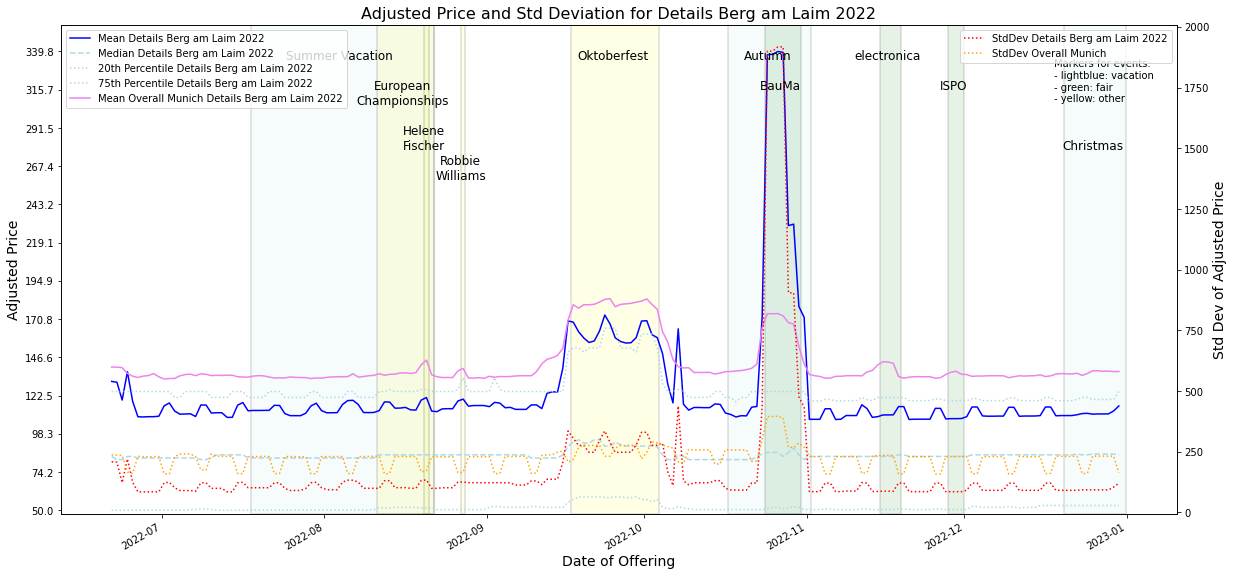

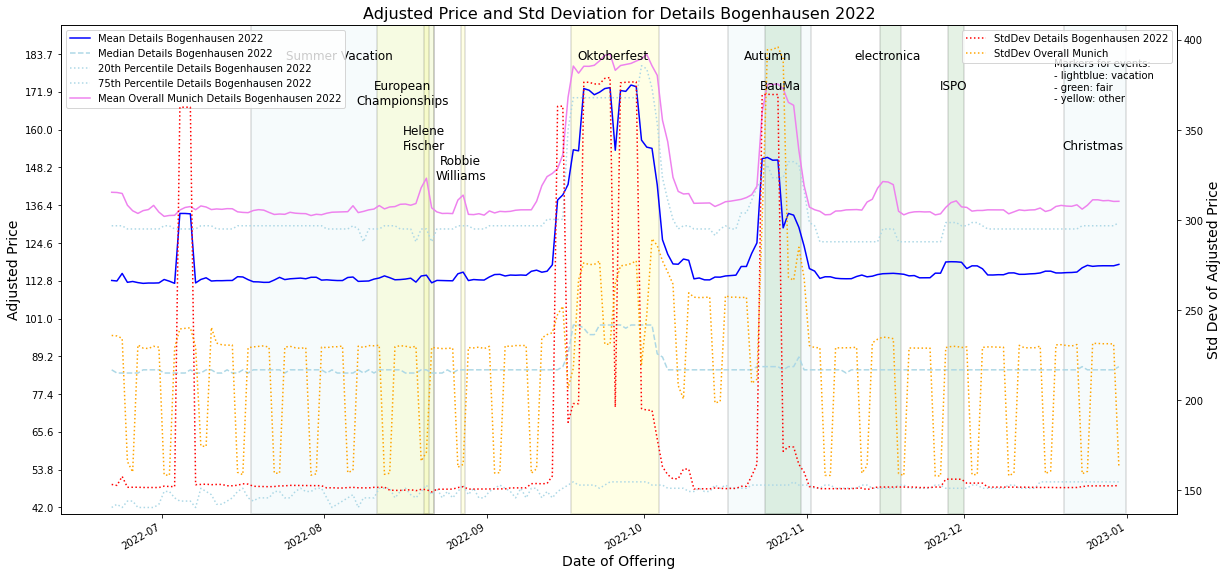

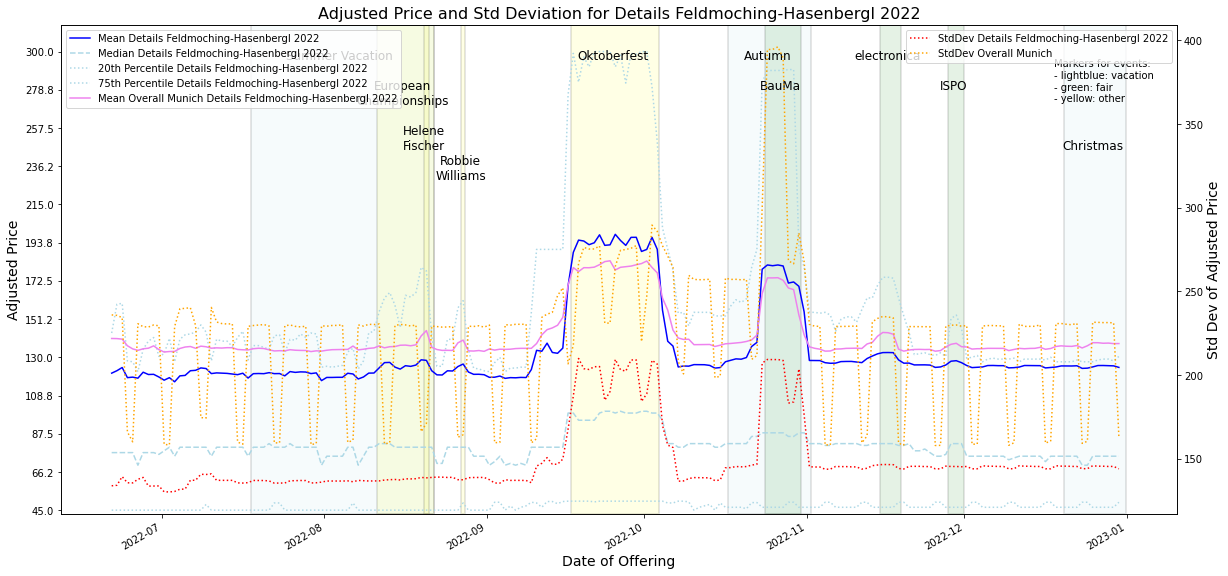

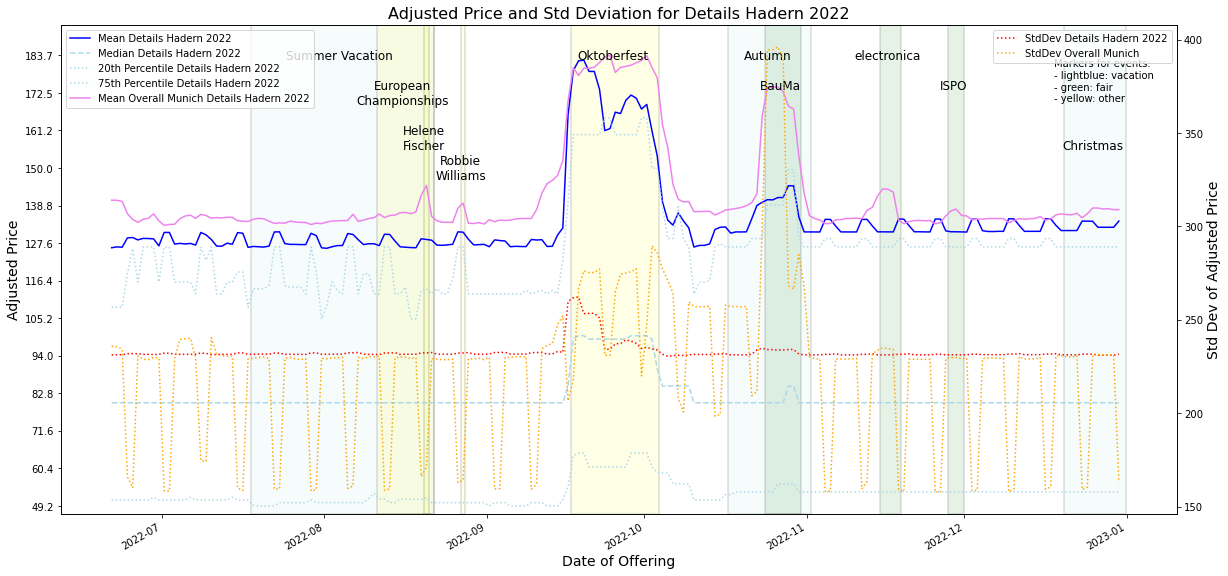

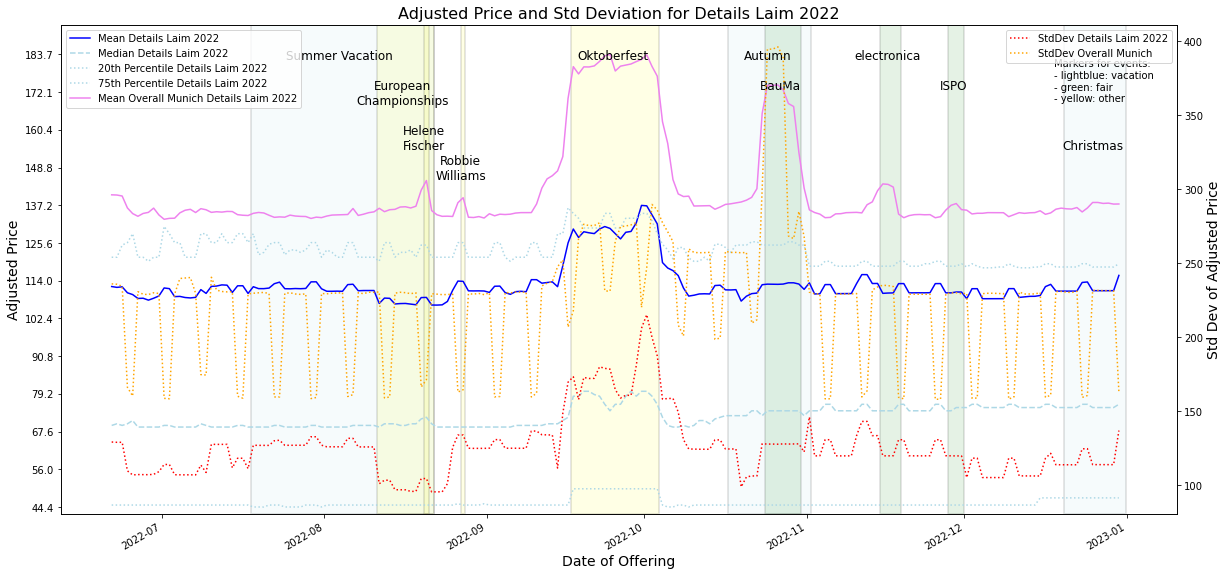

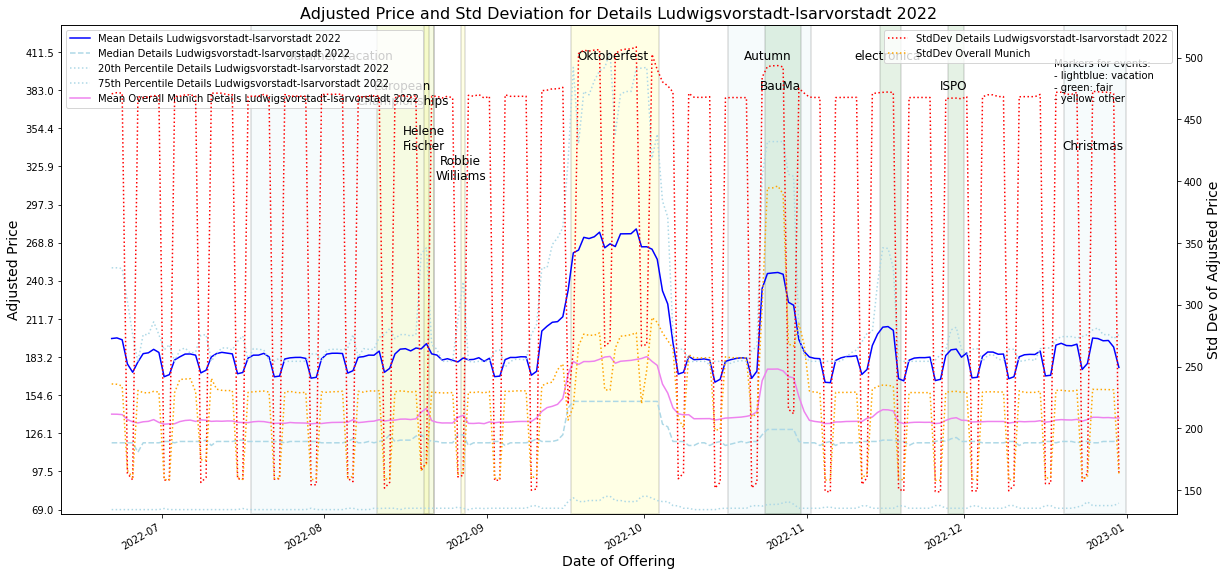

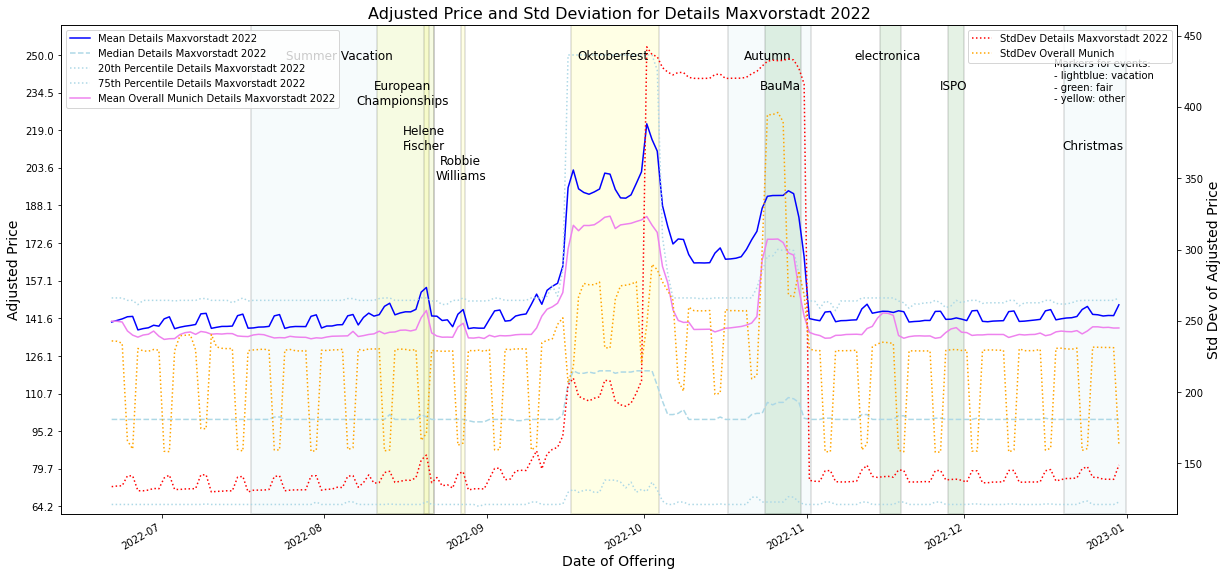

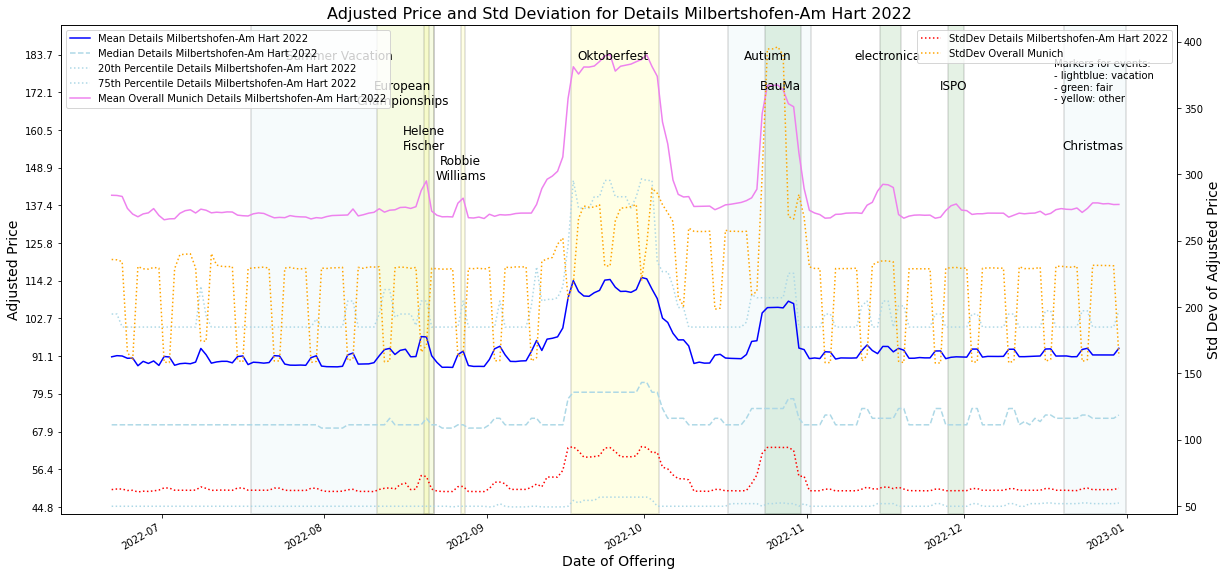

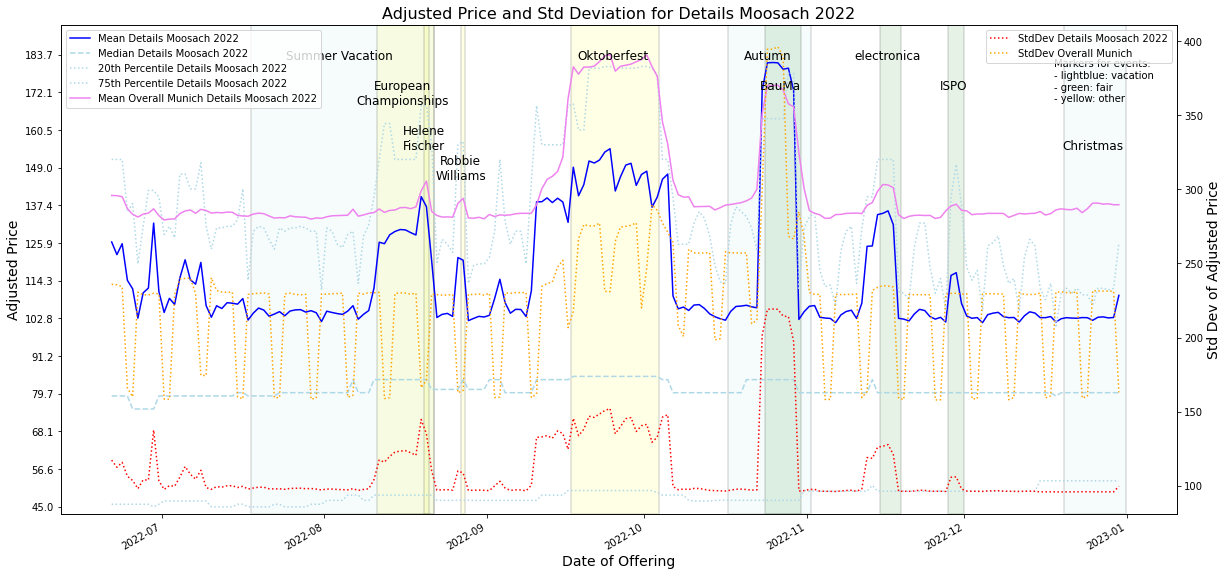

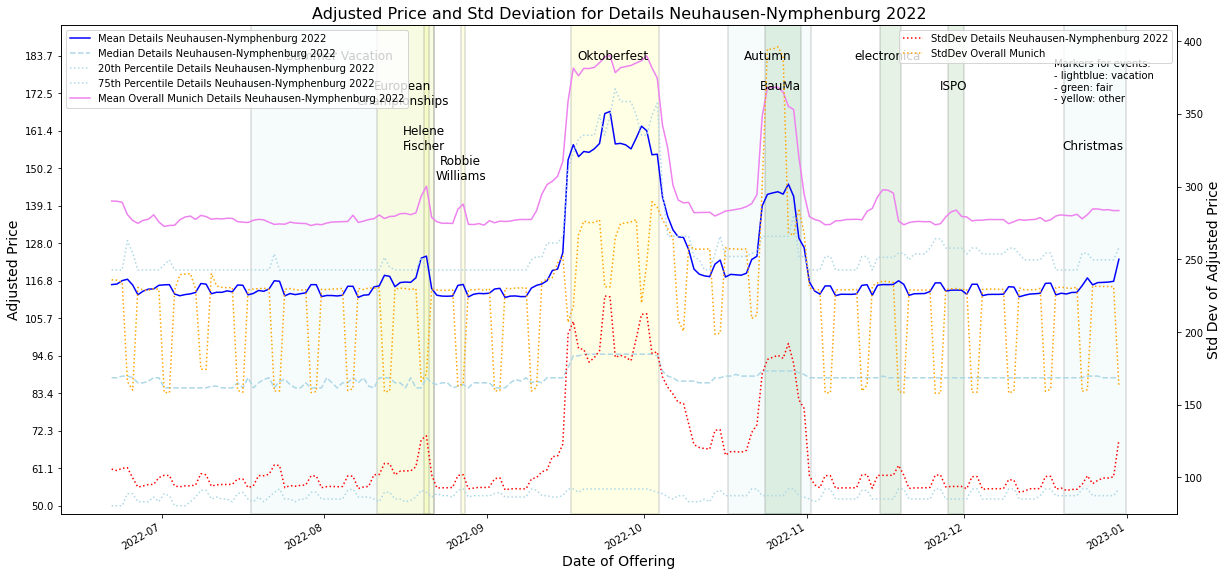

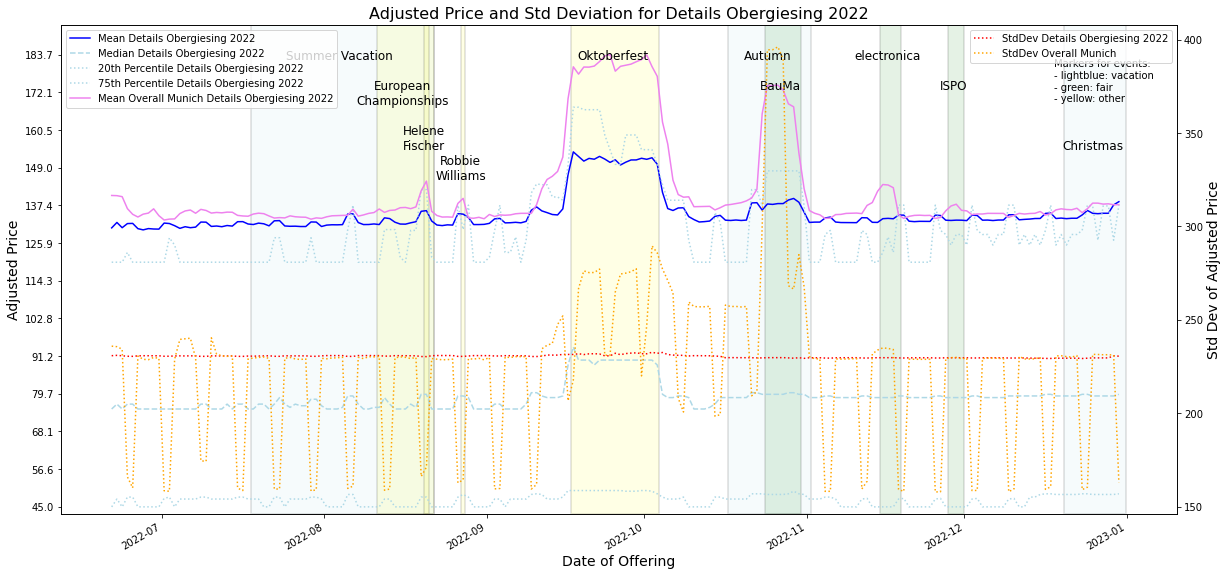

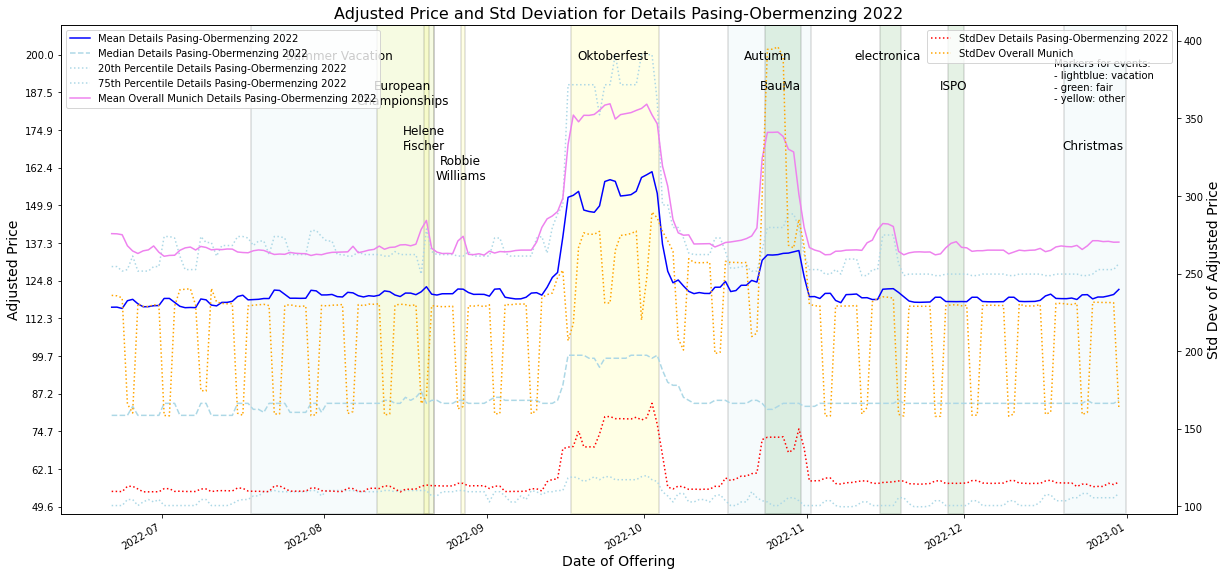

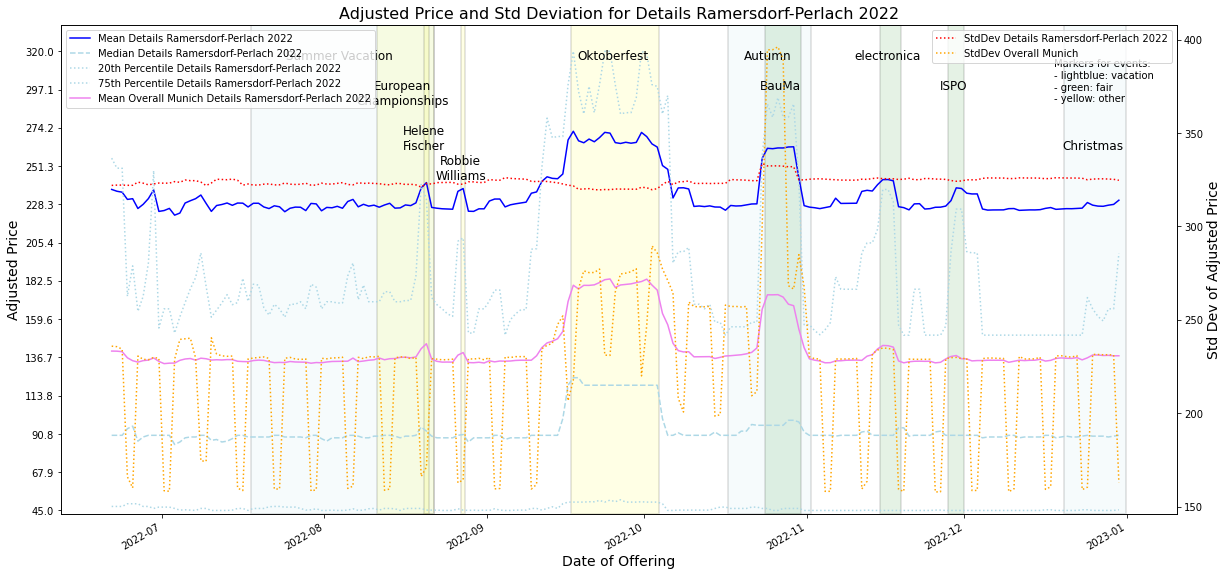

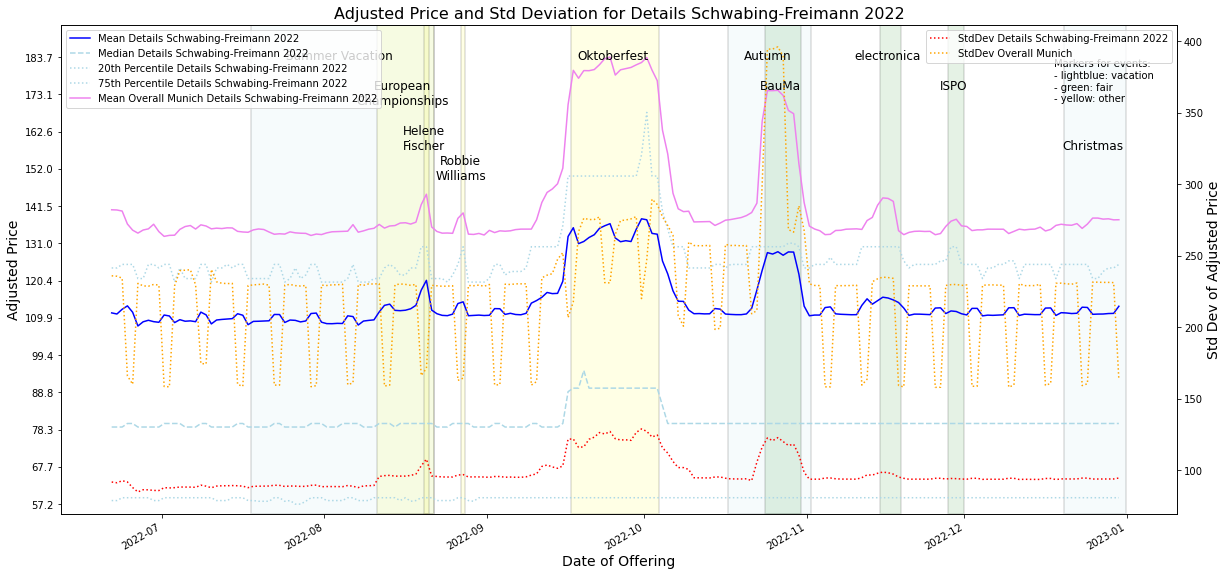

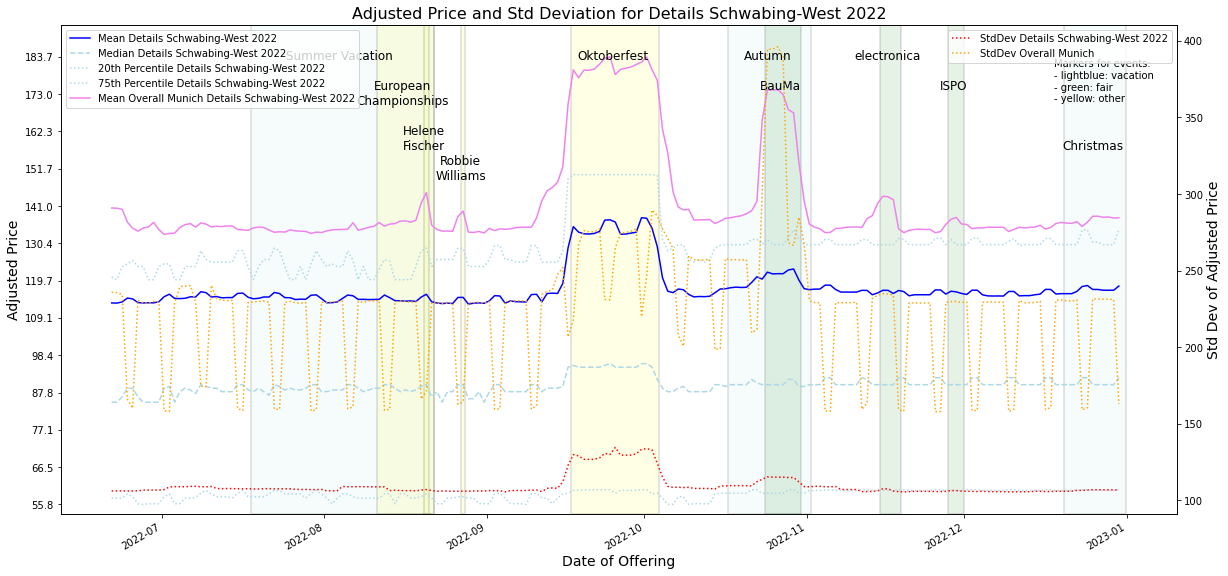

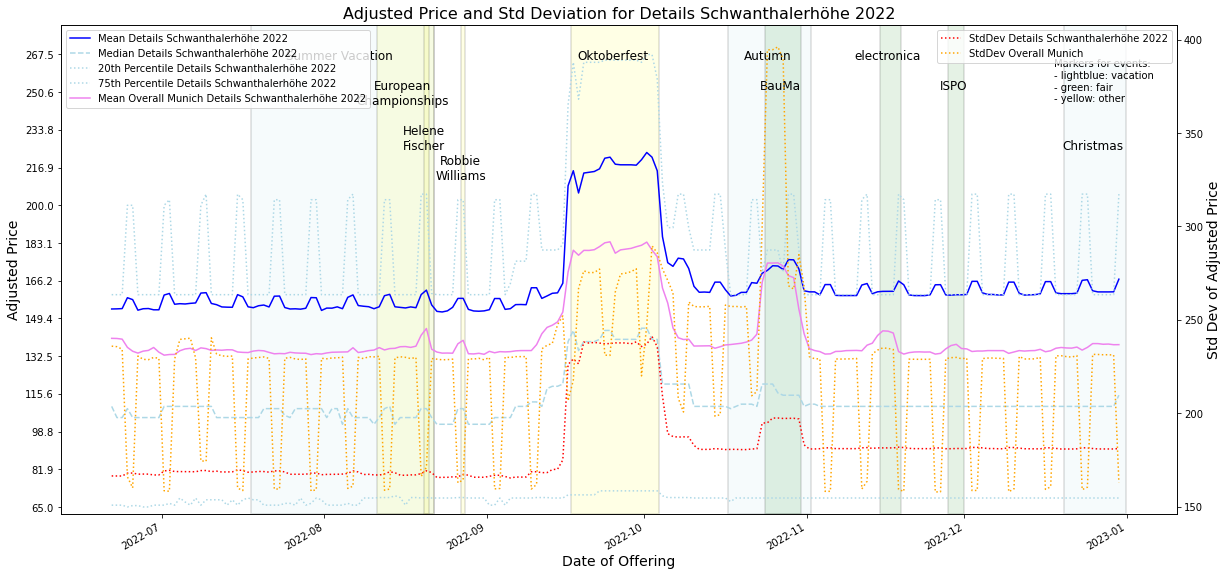

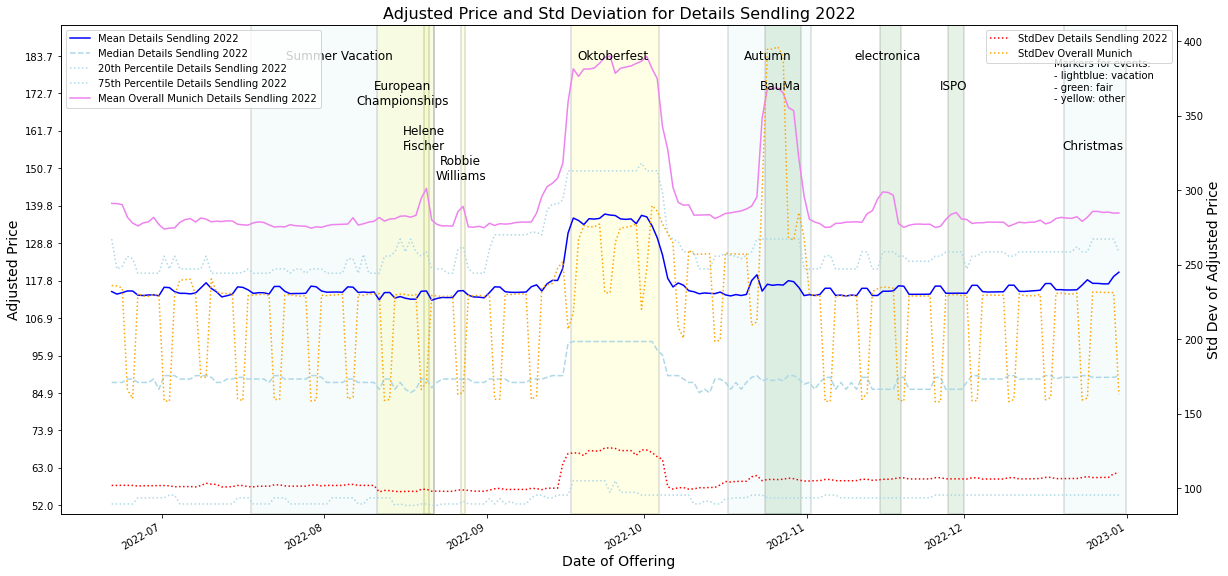

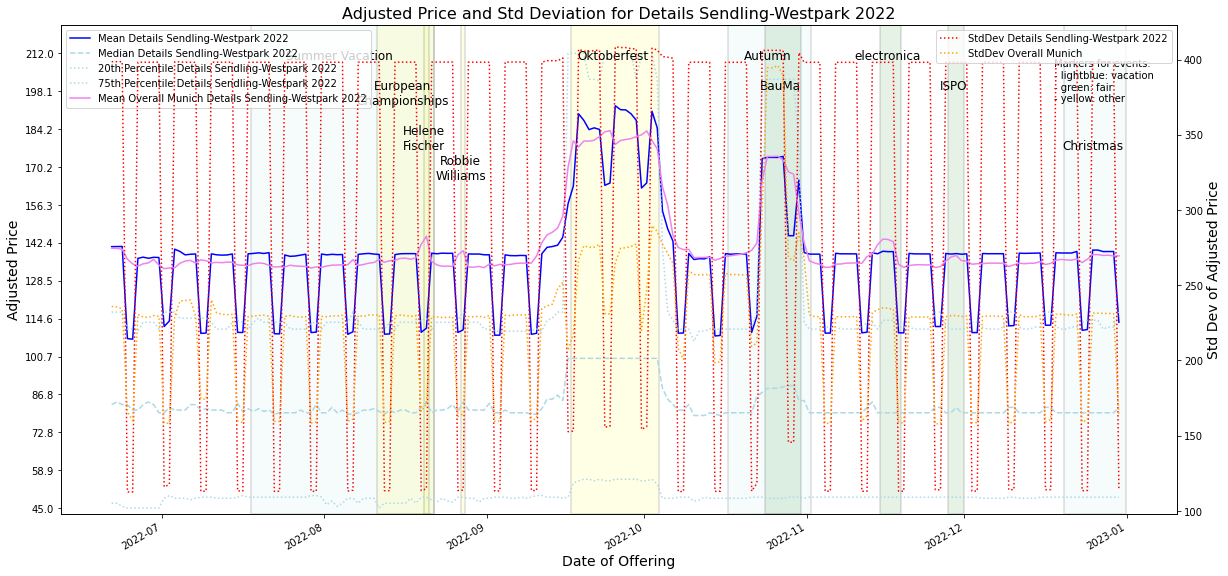

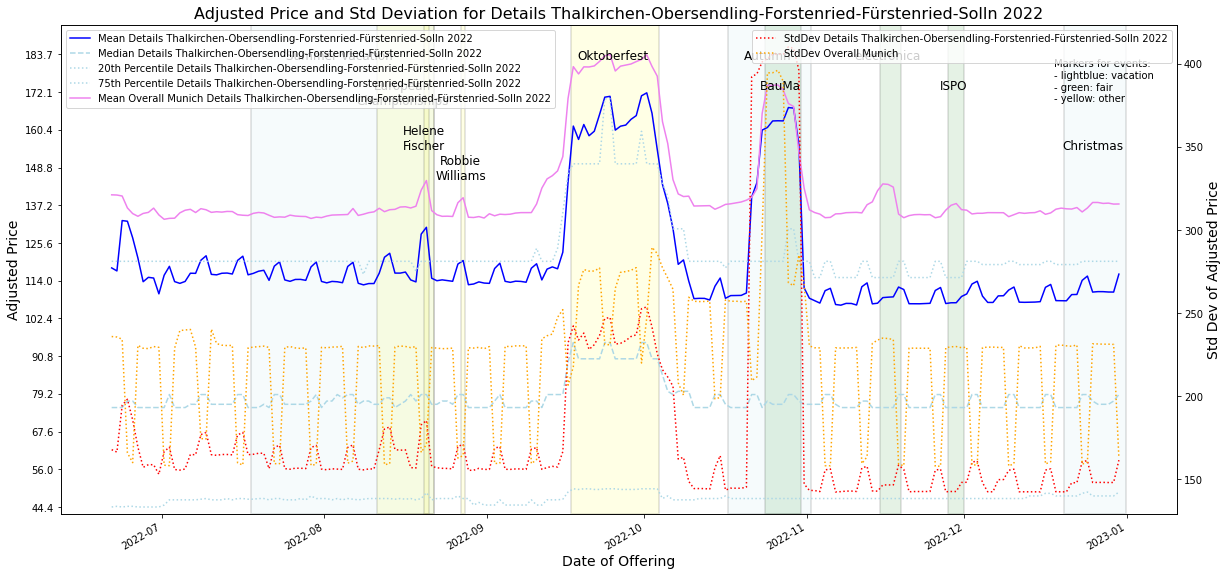

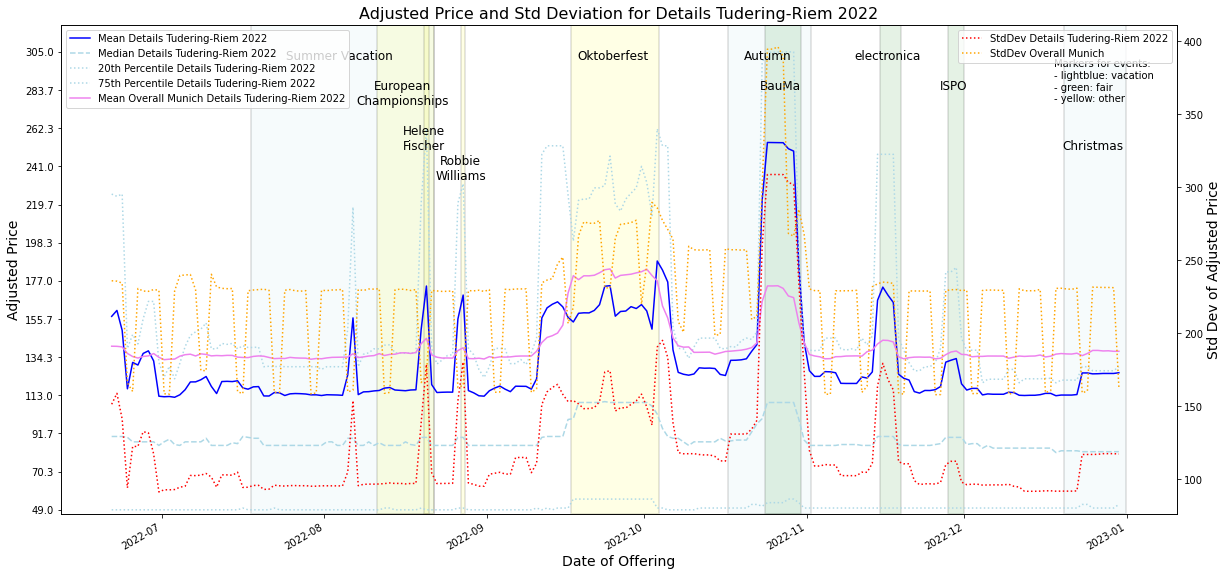

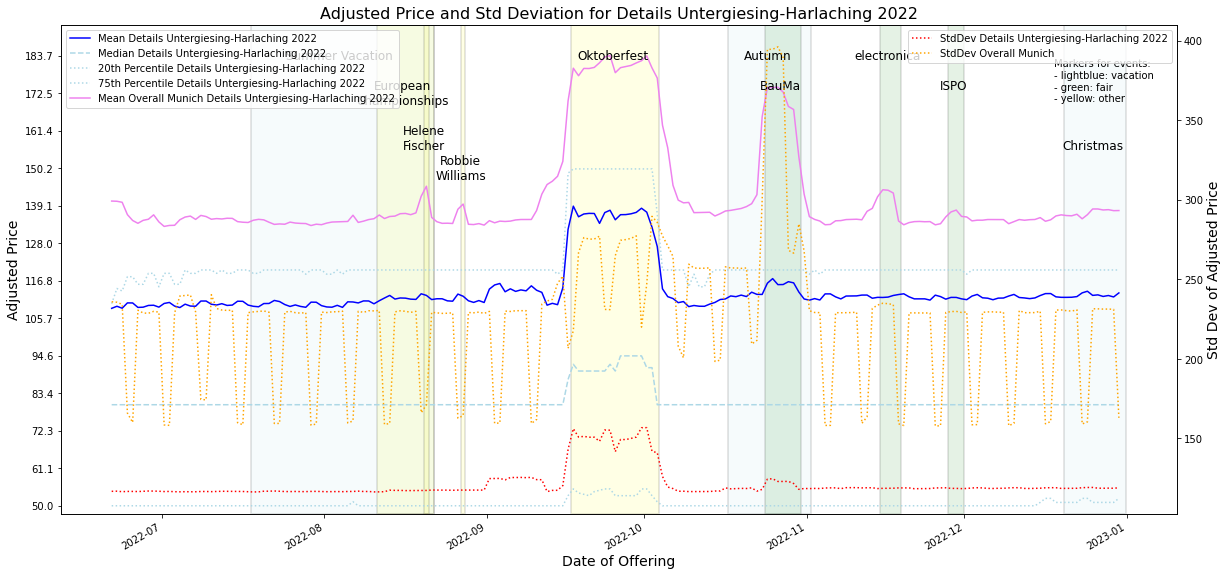

In [21]:
nbhs = list(res['neighbourhood_cleansed'])
df_calendar_mi = df_thisyear.set_index(['neighbourhood_cleansed', 'date'])


for nbh in nbhs:
    df = df_calendar_mi.loc[ nbh, : ]
    create_meanstd_figure( df
                          , df_events[ df_events['From'] <= dt.datetime(2022,12,31) ]
                          , 'Details ' + nbh + ' 2022'
                          , df_ref_mean = df_ty_ref_mean, df_ref_std = df_ty_ref_std
                         )